In [5]:
import os
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Matplotlib is building the font cache; this may take a moment.


In [2]:
# Adjust this to your extracted dataset folder
DATASET_DIR = Path("sample")

IMAGES_DIR = DATASET_DIR / "images"
LABELS_DIR = DATASET_DIR / "labels"

# Output dataset (relabelled)
OUT_DIR = Path("./relabel_dataset")
OUT_IMAGES = OUT_DIR / "images"
OUT_LABELS = OUT_DIR / "labels"

OUT_IMAGES.mkdir(parents=True, exist_ok=True)
OUT_LABELS.mkdir(parents=True, exist_ok=True)

print("Images:", len(list(IMAGES_DIR.glob("*"))))
print("Labels:", len(list(LABELS_DIR.glob("*"))))

Images: 12
Labels: 12


In [12]:
def read_yolo_label(label_path: Path):
    boxes = []
    with open(label_path, "r") as f:
        for line in f.readlines():
            vals = line.strip().split()
            if len(vals) != 5:
                continue
            cls, x, y, w, h = map(float, vals)
            boxes.append((cls, x, y, w, h))
    return boxes

def yolo_to_xyxy(x, y, w, h, img_w, img_h):
    x1 = int((x - w / 2) * img_w)
    y1 = int((y - h / 2) * img_h)
    x2 = int((x + w / 2) * img_w)
    y2 = int((y + h / 2) * img_h)
    return x1, y1, x2, y2

def crop_bbox(img, x, y, w, h):
    h_img, w_img = img.shape[:2]
    x1, y1, x2, y2 = yolo_to_xyxy(x, y, w, h, w_img, h_img)
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w_img, x2), min(h_img, y2)
    return img[y1:y2, x1:x2]

def get_color_category(crop_bgr: np.ndarray) -> int:
    if crop_bgr.size == 0:
        return 2  # fallback to "others"

    hsv = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2HSV)
    mean_hsv = hsv.mean(axis=(0, 1))
    h, s, v = mean_hsv

    # Blue hue is typically 90–140 in OpenCV scale
    if 90 <= h <= 140:
        if v > 100:   # brighter = light blue
            return 0
        else:         # darker = dark blue
            return 1

    return 2  # other colors

In [13]:
label_files = sorted(LABELS_DIR.glob("*.txt"))

print(f"Found {len(label_files)} label files.")

for label_path in tqdm(label_files):
    img_path = IMAGES_DIR / (label_path.stem + ".jpg")
    if not img_path.exists():
        img_path = IMAGES_DIR / (label_path.stem + ".png")
    if not img_path.exists():
        print("Missing image for:", label_path)
        continue

    img = cv2.imread(str(img_path))
    h_img, w_img = img.shape[:2]

    boxes = read_yolo_label(label_path)
    new_lines = []

    for cls, x, y, w, h in boxes:
        crop = crop_bbox(img, x, y, w, h)
        new_cls = get_color_category(crop)
        new_lines.append(f"{new_cls} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

    # save new label
    out_label = OUT_LABELS / label_path.name
    with open(out_label, "w") as f:
        f.writelines(new_lines)

    # copy image
    out_img = OUT_IMAGES / img_path.name
    if not out_img.exists():
        cv2.imwrite(str(out_img), img)

Found 12 label files.


100%|██████████| 12/12 [00:00<00:00, 81.40it/s]


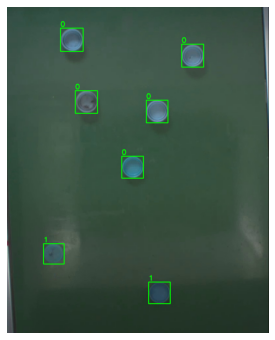

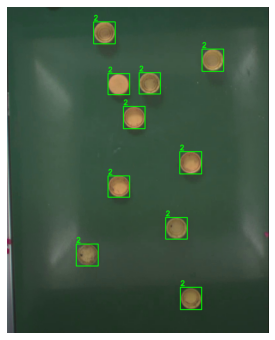

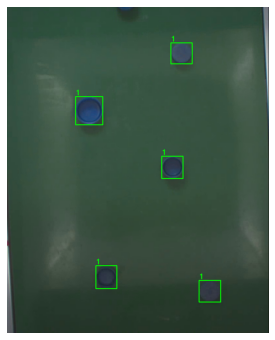

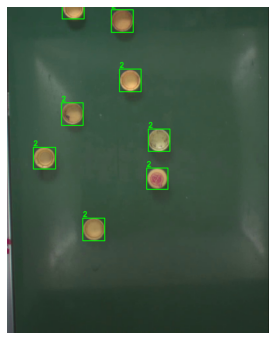

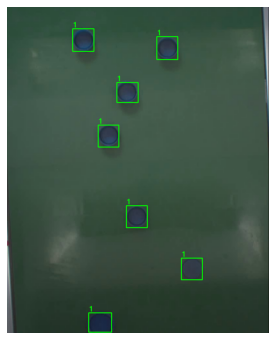

In [14]:
import random

sample_labels = random.sample(list(OUT_LABELS.glob("*.txt")), 5)

for label_path in sample_labels:
    img_path = OUT_IMAGES / (label_path.stem + ".jpg")
    img = cv2.imread(str(img_path))
    h, w, _ = img.shape

    with open(label_path, "r") as f:
        lines = f.readlines()

    plt.figure(figsize=(6,6))
    temp_img = img.copy()

    for line in lines:
        cls, x, y, bw, bh = map(float, line.split())
        x1, y1, x2, y2 = yolo_to_xyxy(x, y, bw, bh, w, h)
        color = (0,255,0)
        cv2.rectangle(temp_img, (x1,y1), (x2,y2), color, 2)
        cv2.putText(temp_img, str(int(cls)), (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

In [15]:
from collections import Counter

dist = Counter()

for label_path in OUT_LABELS.glob("*.txt"):
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls = int(line.split()[0])
            dist[cls] += 1

dist

Counter({2: 47, 0: 11, 1: 21})